**Packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.optimize import curve_fit

from ovito.io import *
from ovito.modifiers import *
from ovito.pipeline import *

# Packages form Henriks Github
from lammps_logfile import running_mean, get_color_value
from regex_file_collector import Collector
from regex_file_collector.utils import floating_number_pattern
import lammps_logfile

**Sigmoidal function**

In [2]:
def sigmoid(x, c, b, a):
    z = b*(x-c)
    return a*np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))

**Laplace of Gaussian**

Equation found at: https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm

In [3]:
def laplaceOfGaussian(x, y, sigma):
    LoG = -1.0/(np.pi * sigma**4) * (1.0-((x**2 + y**2)/(2*sigma**2))) * np.exp(-((x**2 + y**2)/(2*sigma**2)))
    return LoG

**Function: Trajectory to fracture displacement file**

In [4]:
def trajectory_to_fracture_displacement(filename, n_bins=10, reference_frame=7):
    
    # Read in trajectory-file
    pipeline = import_file(filename, multiple_frames=True)

    position_crack_tip = []
    frames = []
    
    frames_posCrack = []
    
    extra_zeros = np.zeros((50))

    for frame in range(reference_frame, pipeline.source.num_frames):
        
        # Coordination analysis:
        pipeline.modifiers.append(CoordinationAnalysisModifier(
            number_of_bins = n_bins, 
            partial = True))

        # Expression selection:
        pipeline.modifiers.append(ExpressionSelectionModifier(
            expression = 'Coordination>=4 || ParticleType==2'))
        #pipeline.modifiers.append(ExpressionSelectionModifier(
        #    expression = 'Coordination>=4 || ParticleType==2 || Position.Y > 118 || Position.Y < 5 || Position.Z > 200 '))
        
        # Delete selected:
        pipeline.modifiers.append(DeleteSelectedModifier())

        # Spatial binning:
        pipeline.modifiers.append(SpatialBinningModifier(
            property = 'Coordination', 
            reduction_operation = SpatialBinningModifier.Operation.Sum, 
            direction = SpatialBinningModifier.Direction.X, 
            bin_count = (95, 200, 200)))

        #Extract and save data as a table
        data = pipeline.compute(frame)
        table = data.tables['binning'].xy()

        pos_x = table[:,0]
        coord = table[:,1]
        
        #mean_pos_x = running_mean(pos_x, 10)
        #mean_coord = running_mean(coord, 10)

        #pos_x = mean_pos_x[7:-7]
        #coord = mean_coord[7:-7]

        diff_pos = pos_x[1]-pos_x[0]

        # Add extra zeroes at the end to get a better fit
        new_pos = []
        for i in range (0, len(extra_zeros)):
            new_pos.append(pos_x[-1]+diff_pos*i)

        pos_x = np.insert(pos_x, len(pos_x), new_pos)
        coord = np.insert(coord, len(coord), extra_zeros)

        # Make a sigmoidal fit (for x3000_y200: 500)
        popt = [200]

        try:
            popt, pcov = curve_fit(sigmoid, pos_x, coord, p0=[popt[0], 0.001, (pos_x[0]+pos_x[-1])/2])
        except RuntimeError as e: 
            print(e)
            popt = [-1]
                
        position_crack_tip.append(popt[0])
        
    return position_crack_tip

**Function: Save as file**

In [5]:
def save_fracture_displacement(filename, overwrite=True, **kwargs):
    outfile = "fracture_displacement"
    
    folder = os.path.dirname(filename)
    
    if overwrite or not os.path.isfile(os.path.join(folder, outfile+".npy")):
        position_crack_tip = trajectory_to_fracture_displacement(filename, **kwargs)
        np.save(os.path.join(folder,outfile), position_crack_tip, allow_pickle=False)

**Function: Save figure as .png**

In [6]:
def save_figure(output_file_name):
    plt.savefig(output_file_name, dpi=None, facecolor='w', edgecolor='w', orientation='portrait')

**Select folder with input files to save data as .npy**

In [8]:
#paths = ['/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.028294/trajectory.bin',
#       '/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.031881/trajectory.bin',
#       '/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.035479/trajectory.bin']

#for path in paths:
#    filename = path
#    print(filename)
#    save_fracture_displacement(filename)


path = '/home/users/marthgg/2021_08_quartz_simulations'
pattern = 'crack_simulation_'+floating_number_pattern('deformZ')+'/trajectory.bin'

collection = Collector(path, pattern, fields=('deformZ'))
simulations = collection.get_flat()

for deformZ, path in simulations.items():
   
    filename = path
    print(filename)
    
    save_fracture_displacement(filename)

The pattern contains 1 capturing groups
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.011000/trajectory.bin
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.018000/trajectory.bin
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.050000/trajectory.bin
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.019855/trajectory.bin
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.035994/trajectory.bin
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.039854/trajectory.bin
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.038000/trajectory.bin
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.031994/trajectory.bin
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.010000/trajectory.bin
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.030000/trajectory.bin


/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too smal

<ipython-input-4-9b105c2bc495>:3: RuntimeWarning: overflow encountered in exp
  return a*np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
<ipython-input-4-9b105c2bc495>:3: RuntimeWarning: invalid value encountered in true_divide
  return a*np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))


Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.019855/trajectory.bin
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns

**Read in data saved as .npy**

The pattern contains 1 capturing groups
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.042714/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.053649/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.056894/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.066689/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.050000/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.037285/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.076575/fracture_displacement.npy
/home/us

/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.086553/fracture_displacement.npy
18
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.100000/fracture_displacement.npy
16
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.060149/fracture_displacement.npy
28


/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


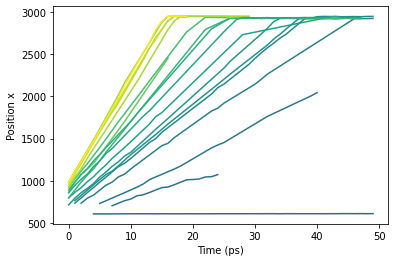

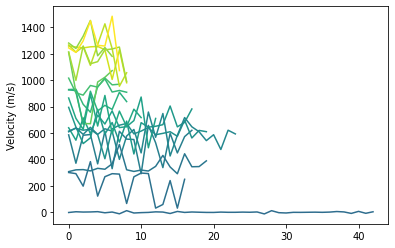

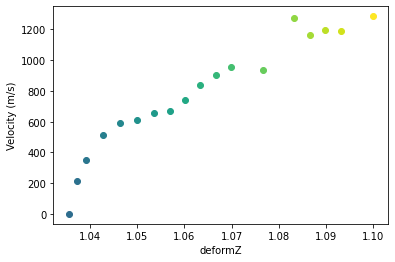

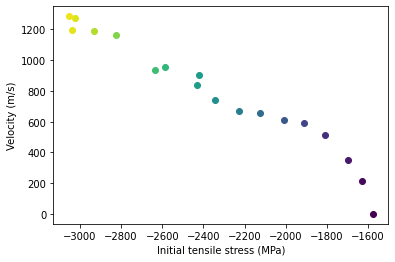

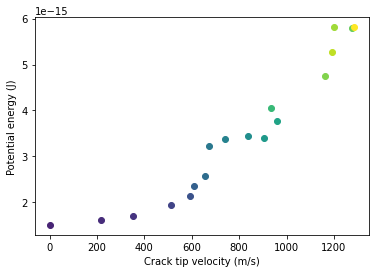

In [142]:
path = '/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200'
pattern = 'crack_simulation_'+floating_number_pattern('deformZ')+'/fracture_displacement.npy'

collection = Collector(path, pattern, fields=('deformZ'))
simulations = collection.get_flat()

system_length = 3000
crack_start_point = 150

for deformZ, path in simulations.items():
        
    filename = path

    data = np.load(filename, allow_pickle=False)
    frames = list(range(0, len(data)))

    filtered_data_crackTip = []
    filtered_data_frames   = []

    for i in range(0, len(data)):
        if data[i] > crack_start_point and data[i] < system_length:
            filtered_data_crackTip.append(data[i])
            filtered_data_frames.append(frames[i])            
    
    for i in range(0, len(filtered_data_frames)):
        if filtered_data_crackTip[i] > 2910:
            print(filename)
            print(filtered_data_frames[i])
            break

    # Find velocity
    timestep = 0.001 # ps
    dump_frequency = 10000

    time_s = []
    time = []
    for i in range(0, len(filtered_data_frames)):
        time.append(filtered_data_frames[i]*timestep*dump_frequency) #Time in ps
        if filtered_data_crackTip[i] < 2910:
            time_s.append(filtered_data_frames[i]*timestep*dump_frequency*(10**-12)) #time in s

    position_m = []
    for i in range(0, len(filtered_data_crackTip)):
        if filtered_data_crackTip[i] < 2910:
            position_m.append(filtered_data_crackTip[i]*(10**-10)) #distance in m

    velocity = np.diff(position_m)/np.diff(time_s)
    mean_velocity = np.mean(velocity)
   
    plt.figure(1)
    plt.plot(filtered_data_frames, filtered_data_crackTip, color=get_color_value(float(deformZ), 1.000000, 1.100000))
    plt.xlabel('Time (ps)')
    plt.ylabel('Position x')
    
    #save_figure('/home/users/marthgg/img/noRot_velocities.png')
    
    plt.figure(2)
    plt.plot(velocity, color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.ylabel('Velocity (m/s)')

    plt.figure(3)
    plt.plot(float(deformZ), mean_velocity, 'o', color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.xlabel('deformZ')
    plt.ylabel('Velocity (m/s)')
    
    logfile = '/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_%s/log.lammps' %deformZ

    log = lammps_logfile.File(logfile)
    pzz = log.get('Pzz')
    min_pressure = np.min(pzz)
    
    pot = log.get('PotEng')
    
    plt.figure(4)
    plt.plot(min_pressure/10, mean_velocity, 'o', color=get_color_value((min_pressure/10), -1600, -3100))
    plt.xlabel('Initial tensile stress (MPa)')
    plt.ylabel('Velocity (m/s)')
    
    #save_figure('/home/users/marthgg/img/noRot_velocities_vs_tensileStress.png')    
    
    min_pot = np.min(pot)
    pot = pot[200:]
    #min_pot = np.min(pot)
    min_pot_crack = np.min(pot[100:])
    
    delta_up = min_pot_crack - min_pot #eV
    delta_up_J = delta_up * 1.60218e-19 #Joules

    plt.figure(5)
    plt.plot(mean_velocity, delta_up_J, 'o', color=get_color_value(float(deformZ), 1.028294, 1.100000))
    plt.ylabel('Potential energy (J)')
    plt.xlabel('Crack tip velocity (m/s)')
    
    #save_figure('/home/users/marthgg/img/noRot_velocities_vs_potentialEnergy.png')  


The pattern contains 1 capturing groups
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.042714/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.053649/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.056894/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.066689/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.050000/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.037285/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.076575/fracture_displacement.npy
/home/us

/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.086553/fracture_displacement.npy
16
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.100000/fracture_displacement.npy
14
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.060149/fracture_displacement.npy
25
The pattern contains 1 capturing groups
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_30/crack_simulation_deformZ_1.042714/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_30/crack_simulation_deformZ_1.053649/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_30/crack_simulation_deformZ_1.056894/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_30/crack_simulation_deformZ_1.066689/fracture_displacement.npy
/home/u

/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/user

/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.042714/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.053649/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.056894/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.066689/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.050000/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.076575/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.046351/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structu

/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.076575/fracture_displacement.npy
3


/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.046351/fracture_displacement.npy
47
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.063414/fracture_displacement.npy
7
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.069974/fracture_displacement.npy
4
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.093256/fracture_displacement.npy
0


/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.086553/fracture_displacement.npy
3
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.100000/fracture_displacement.npy
0


/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_1.060149/fracture_displacement.npy
9


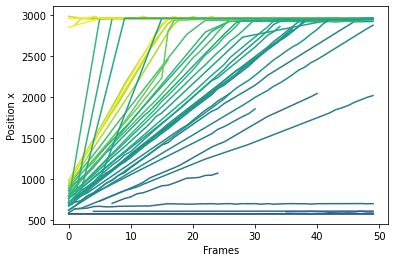

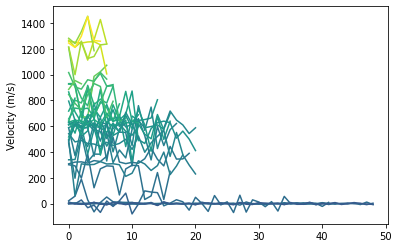

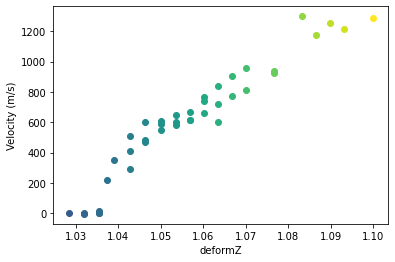

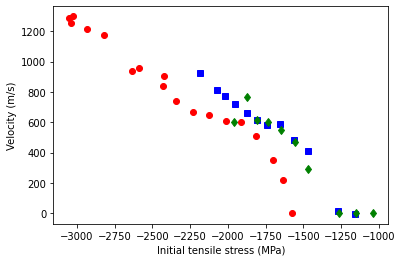

In [150]:
path = '/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200'
pattern = 'crack_simulation_'+floating_number_pattern('deformZ')+'/fracture_displacement.npy'

collection = Collector(path, pattern, fields=('deformZ'))
simulations = collection.get_flat()

system_length = 3000
crack_start_point = 150

for deformZ, path in simulations.items():
        
    filename = path

    data = np.load(filename, allow_pickle=False)
    frames = list(range(0, len(data)))

    filtered_data_crackTip = []
    filtered_data_frames   = []

    for i in range(0, len(data)):
        if data[i] > crack_start_point and data[i] < system_length:
            filtered_data_crackTip.append(data[i])
            filtered_data_frames.append(frames[i])            

    plt.figure(1)
    plt.plot(filtered_data_frames, filtered_data_crackTip, color=get_color_value(float(deformZ), 1.000000, 1.100000))
    plt.xlabel('Frames')
    plt.ylabel('Position x')

    #save_figure('/home/users/marthgg/simulations/x3000_y200/vary_deformZ/noRot_frames_vs_positionX.png')
    
    for i in range(0, len(filtered_data_frames)):
        if filtered_data_crackTip[i] > 2700:
            print(filename)
            print(filtered_data_frames[i])
            break

    # Find velocity
    timestep = 0.001 # ps
    dump_frequency = 10000

    time_s = []
    for i in range(0, len(filtered_data_frames)):
        if filtered_data_crackTip[i] < 2700:
            time_s.append(filtered_data_frames[i]*timestep*dump_frequency*(10**-12)) #time in s

    position_m = []
    for i in range(0, len(filtered_data_crackTip)):
        if filtered_data_crackTip[i] < 2700:
            position_m.append(filtered_data_crackTip[i]*(10**-10)) #distance in m

    velocity = np.diff(position_m)/np.diff(time_s)

    plt.figure(2)
    plt.plot(velocity, color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.ylabel('Velocity (m/s)')

    mean_velocity = np.mean(velocity)

    plt.figure(3)
    plt.plot(float(deformZ), mean_velocity, 'o', color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.xlabel('deformZ')
    plt.ylabel('Velocity (m/s)')
    
    #save_figure('/home/users/marthgg/simulations/x3000_y200/vary_deformZ/noRot_velocities.png')

    logfile = '/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_%s/log.lammps' %deformZ

    log = lammps_logfile.File(logfile)
    pzz = log.get('Pzz')
    min_pressure = np.min(pzz)
    
    plt.figure(4)
    plt.plot(min_pressure/10, mean_velocity, 'o', color='red')#, color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.xlabel('extensional loading (MPa)')
    plt.ylabel('Velocity (m/s)')
    #save_figure('/home/users/marthgg/simulations/x3000_y200/vary_deformZ/noRot_deformZ_vs_velocity.png')
    
    
    
path = '/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_30'
pattern = 'crack_simulation_'+floating_number_pattern('deformZ')+'/fracture_displacement.npy'

collection = Collector(path, pattern, fields=('deformZ'))
simulations = collection.get_flat()

system_length = 3000
crack_start_point = 150

for deformZ, path in simulations.items():
        
    filename = path

    data = np.load(filename, allow_pickle=False)
    frames = list(range(0, len(data)))

    filtered_data_crackTip = []
    filtered_data_frames   = []

    for i in range(0, len(data)):
        if data[i] > crack_start_point and data[i] < system_length:
            filtered_data_crackTip.append(data[i])
            filtered_data_frames.append(frames[i])            

    plt.figure(1)
    plt.plot(filtered_data_frames, filtered_data_crackTip, color=get_color_value(float(deformZ), 1.000000, 1.100000))
    plt.xlabel('Frames')
    plt.ylabel('Position x')

    #save_figure('/home/users/marthgg/simulations/x3000_y200/vary_deformZ/noRot_frames_vs_positionX.png')
    
    for i in range(0, len(filtered_data_frames)):
        if filtered_data_crackTip[i] > 2700:
            print(filename)
            print(filtered_data_frames[i])
            break

    # Find velocity
    timestep = 0.001 # ps
    dump_frequency = 10000

    time_s = []
    for i in range(0, len(filtered_data_frames)):
        if filtered_data_crackTip[i] < 2700:
            time_s.append(filtered_data_frames[i]*timestep*dump_frequency*(10**-12)) #time in s

    position_m = []
    for i in range(0, len(filtered_data_crackTip)):
        if filtered_data_crackTip[i] < 2700:
            position_m.append(filtered_data_crackTip[i]*(10**-10)) #distance in m

    velocity = np.diff(position_m)/np.diff(time_s)

    plt.figure(2)
    plt.plot(velocity, color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.ylabel('Velocity (m/s)')

    mean_velocity = np.mean(velocity)

    plt.figure(3)
    plt.plot(float(deformZ), mean_velocity, 'o', color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.xlabel('deformZ')
    plt.ylabel('Velocity (m/s)')
    
    #save_figure('/home/users/marthgg/simulations/x3000_y200/vary_deformZ/noRot_velocities.png')

    logfile = '/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_30/crack_simulation_deformZ_%s/log.lammps' %deformZ

    log = lammps_logfile.File(logfile)
    pzz = log.get('Pzz')
    min_pressure = np.min(pzz)
    
    plt.figure(4)
    plt.plot(min_pressure/10, mean_velocity, 's', color='blue')#, color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.xlabel('extensional loading (MPa)')
    plt.ylabel('Velocity (m/s)')
    #save_figure('/home/users/marthgg/simulations/x3000_y200/vary_deformZ/noRot_deformZ_vs_velocity.png')


path = '/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60'
pattern = 'crack_simulation_'+floating_number_pattern('deformZ')+'/fracture_displacement.npy'

collection = Collector(path, pattern, fields=('deformZ'))
simulations = collection.get_flat()

system_length = 3000
crack_start_point = 150

for deformZ, path in simulations.items():
        
    filename = path

    data = np.load(filename, allow_pickle=False)
    frames = list(range(0, len(data)))

    filtered_data_crackTip = []
    filtered_data_frames   = []

    for i in range(0, len(data)):
        if data[i] > crack_start_point and data[i] < system_length:
            filtered_data_crackTip.append(data[i])
            filtered_data_frames.append(frames[i])            

    plt.figure(1)
    plt.plot(filtered_data_frames, filtered_data_crackTip, color=get_color_value(float(deformZ), 1.000000, 1.100000))
    plt.xlabel('Frames')
    plt.ylabel('Position x')

    #save_figure('/home/users/marthgg/simulations/x3000_y200/vary_deformZ/noRot_frames_vs_positionX.png')
    
    for i in range(0, len(filtered_data_frames)):
        if filtered_data_crackTip[i] > 2700:
            print(filename)
            print(filtered_data_frames[i])
            break

    # Find velocity
    timestep = 0.001 # ps
    dump_frequency = 10000

    time_s = []
    for i in range(0, len(filtered_data_frames)):
        if filtered_data_crackTip[i] < 2700:
            time_s.append(filtered_data_frames[i]*timestep*dump_frequency*(10**-12)) #time in s

    position_m = []
    for i in range(0, len(filtered_data_crackTip)):
        if filtered_data_crackTip[i] < 2700:
            position_m.append(filtered_data_crackTip[i]*(10**-10)) #distance in m

    velocity = np.diff(position_m)/np.diff(time_s)

    plt.figure(2)
    plt.plot(velocity, color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.ylabel('Velocity (m/s)')

    mean_velocity = np.mean(velocity)

    plt.figure(3)
    plt.plot(float(deformZ), mean_velocity, 'o', color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.xlabel('deformZ')
    plt.ylabel('Velocity (m/s)')
    
    #save_figure('/home/users/marthgg/simulations/x3000_y200/vary_deformZ/noRot_velocities.png')

    logfile = '/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/angle_60/crack_simulation_deformZ_%s/log.lammps' %deformZ

    log = lammps_logfile.File(logfile)
    pzz = log.get('Pzz')
    min_pressure = np.min(pzz)
    
    plt.figure(4)
    plt.plot(min_pressure/10, mean_velocity, 'd', color='green')#, color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.xlabel('Initial tensile stress (MPa)')
    plt.ylabel('Velocity (m/s)')
    #plt.legend('Angle: 60')
    save_figure('/home/users/marthgg/img/all_tensileStress_vs_velocity.png')

**Old simulations (wrong pzz in the beginning)**

The pattern contains 1 capturing groups
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.042714/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.053649/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.056894/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.066689/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.050000/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.076575/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_1.046351/fracture_displacement.npy
/home/us

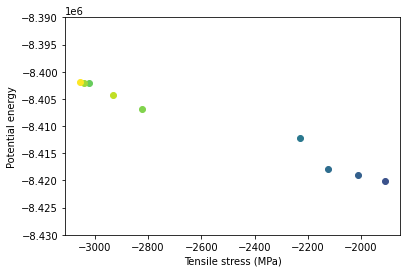

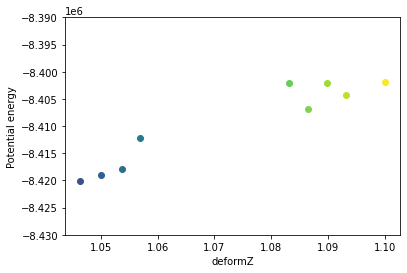

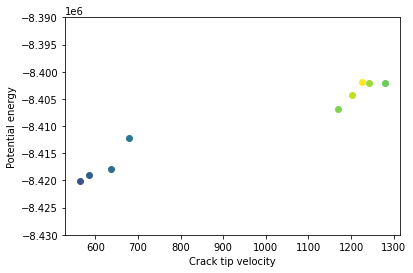

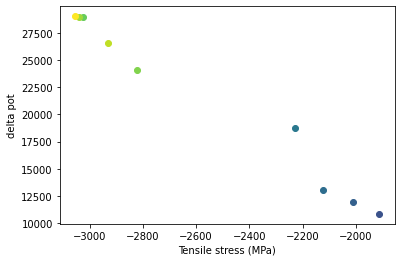

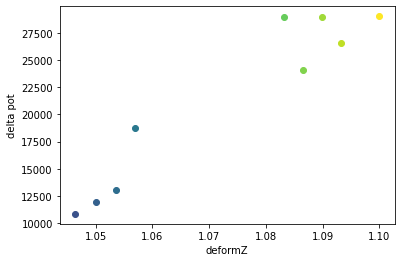

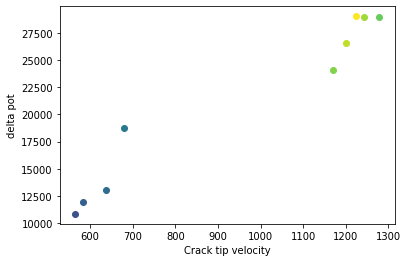

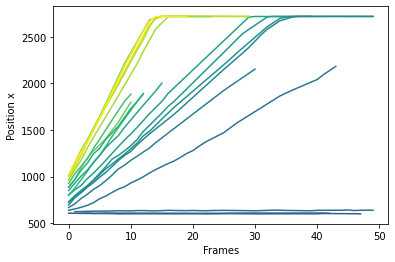

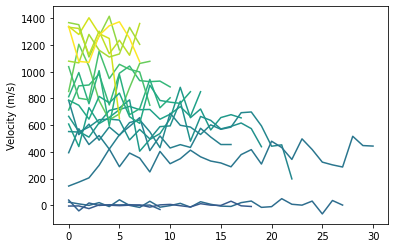

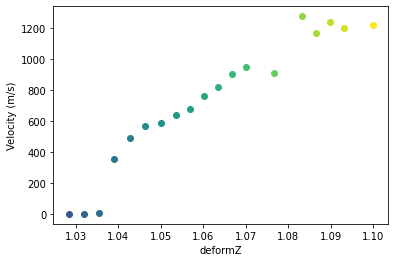

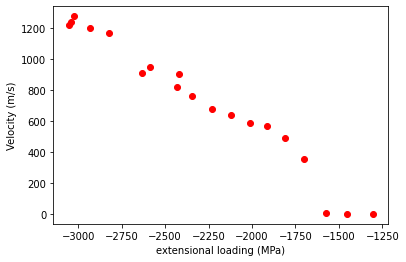

In [103]:
path = '/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200'
pattern = 'crack_simulation_'+floating_number_pattern('deformZ')+'/fracture_displacement.npy'

collection = Collector(path, pattern, fields=('deformZ'))
simulations = collection.get_flat()

system_length = 3000
crack_start_point = 150

for deformZ, path in simulations.items():
        
    filename = path

    data = np.load(filename, allow_pickle=False)
    frames = list(range(0, len(data)))

    filtered_data_crackTip = []
    filtered_data_frames   = []

    for i in range(0, len(data)):
        if data[i] > crack_start_point and data[i] < system_length:
            filtered_data_crackTip.append(data[i])
            filtered_data_frames.append(frames[i])            
    
    #for i in range(0, len(filtered_data_frames)):
    #    if filtered_data_crackTip[i] > 2700:
    #        end_of_crack = filtered_data_frames[i]
    #        print(end_of_crack)
    #        break
    #    else:
    #        end_of_crack = 0
            
    plt.figure(1)
    plt.plot(filtered_data_frames, filtered_data_crackTip, color=get_color_value(float(deformZ), 1.000000, 1.100000))
    plt.xlabel('Frames')
    plt.ylabel('Position x')

    # Find velocity
    timestep = 0.001 # ps
    dump_frequency = 10000

    time_s = []
    for i in range(0, len(filtered_data_frames)):
        if filtered_data_crackTip[i] < 2700:
            time_s.append(filtered_data_frames[i]*timestep*dump_frequency*(10**-12)) #time in s

    position_m = []
    for i in range(0, len(filtered_data_crackTip)):
        if filtered_data_crackTip[i] < 2700:
            position_m.append(filtered_data_crackTip[i]*(10**-10)) #distance in m

    velocity = np.diff(position_m)/np.diff(time_s)

    plt.figure(2)
    plt.plot(velocity, color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.ylabel('Velocity (m/s)')

    mean_velocity = np.mean(velocity)

    plt.figure(3)
    plt.plot(float(deformZ), mean_velocity, 'o', color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.xlabel('deformZ')
    plt.ylabel('Velocity (m/s)')
    
    logfile = '/home/users/marthgg/2021_05_simulations_quartz_relaxed_structure/x3000_y200/crack_simulation_deformZ_%s/log.lammps' %deformZ

    log = lammps_logfile.File(logfile)
    pzz = log.get('Pzz')
    min_pressure = np.min(pzz)
            
    pot = log.get('PotEng')
    mean_pot = running_mean(pot, 10)
    pot = mean_pot[70:-70]
    
    plt.figure(4)
    plt.plot(min_pressure/10, mean_velocity, 'o', color='red')#, color=get_color_value(float(deformZ), 1.00000, 1.10000))
    plt.xlabel('extensional loading (MPa)')
    plt.ylabel('Velocity (m/s)')   
    
    for i in range(0, len(filtered_data_frames)):
        if filtered_data_crackTip[i] > 2715:
            
            #ata_positions = np.array([1,10])*(i*10)
            #print(data_positions)
            
            min_pot_eng = np.min(pot)
            
            min_pot_eng_crack = np.min(pot[200:])
            
            delta_pot = min_pot_eng_crack - min_pot_eng

            plt.figure(5)
            plt.plot(min_pressure/10, min_pot_eng_crack, 'o', color=get_color_value(float(deformZ), 1.028294, 1.10000))
            plt.xlabel('Tensile stress (MPa)')
            plt.ylabel('Potential energy')
            plt.ylim([-8.43e6, -8.39e6])
            
            plt.figure(6)
            plt.plot(float(deformZ), min_pot_eng_crack, 'o', color=get_color_value(float(deformZ), 1.028294, 1.10000))
            plt.xlabel('deformZ')
            plt.ylabel('Potential energy')
            plt.ylim([-8.43e6, -8.39e6])
            
            plt.figure(7)
            plt.plot(mean_velocity, min_pot_eng_crack, 'o', color=get_color_value(float(deformZ), 1.028294, 1.10000))
            plt.xlabel('Crack tip velocity')
            plt.ylabel('Potential energy')
            plt.ylim([-8.43e6, -8.39e6])
            
            
            plt.figure(8)
            plt.plot(min_pressure/10, delta_pot, 'o', color=get_color_value(float(deformZ), 1.028294, 1.10000))
            plt.xlabel('Tensile stress (MPa)')
            plt.ylabel('delta pot')
            #plt.ylim([-8.43e6, -8.39e6])
            
            plt.figure(9)
            plt.plot(float(deformZ), delta_pot, 'o', color=get_color_value(float(deformZ), 1.028294, 1.10000))
            plt.xlabel('deformZ')
            plt.ylabel('delta pot')
            #plt.ylim([-8.43e6, -8.39e6])
            
            plt.figure(10)
            plt.plot(mean_velocity, delta_pot, 'o', color=get_color_value(float(deformZ), 1.028294, 1.10000))
            plt.xlabel('Crack tip velocity')
            plt.ylabel('delta pot')
            #plt.ylim([-8.43e6, -8.39e6])
            
            break

The pattern contains 1 capturing groups
/home/users/marthgg/2021_05_simulations_quartz/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.007497/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.024040/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.022224/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.030002/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.029500/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.042279/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_quartz/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.033057/fracture_displacement.npy
/home/users/marthgg/2021_05_simulations_qua

/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


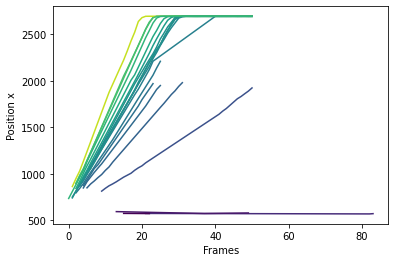

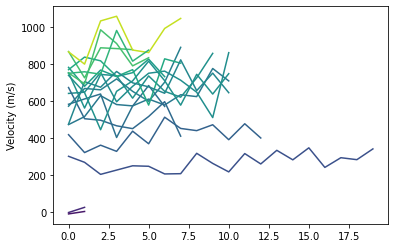

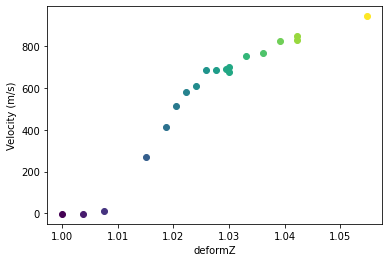

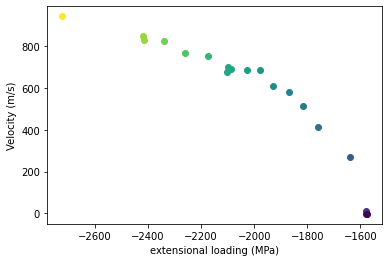

In [20]:
path = '/home/users/marthgg/2021_05_simulations_quartz/x3000_y200/vary_deformZ'
pattern = 'crack_simulation_'+floating_number_pattern('deformZ')+'/fracture_displacement.npy'

collection = Collector(path, pattern, fields=('deformZ'))
simulations = collection.get_flat()

system_length = 3000
crack_start_point = 150

for deformZ, path in simulations.items():
    
    filename = path
    
    data = np.load(filename, allow_pickle=False)
    frames = list(range(0, len(data)))
    
    filtered_data_crackTip = []
    filtered_data_frames   = []
    
    for i in range(0, len(data)):
        if data[i] > crack_start_point and data[i] < system_length:
            filtered_data_crackTip.append(data[i])
            filtered_data_frames.append(frames[i])            
    
    plt.figure(1)
    plt.plot(filtered_data_frames, filtered_data_crackTip, color=get_color_value(float(deformZ), 1.000000, 1.060000))
    plt.xlabel('Frames')
    plt.ylabel('Position x')    
    
    # Find velocity
    timestep = 0.001 # ps
    dump_frequency = 10000
    
    time_s = []
    for i in range(0, len(filtered_data_frames)):
        if filtered_data_crackTip[i] < 2500:
            time_s.append(filtered_data_frames[i]*timestep*dump_frequency*(10**-12)) #time in s
        
    position_m = []
    for i in range(0, len(filtered_data_crackTip)):
        if filtered_data_crackTip[i] < 2500:
            position_m.append(filtered_data_crackTip[i]*(10**-10)) #distance in m
        
    velocity = np.diff(position_m)/np.diff(time_s)
    
    plt.figure(2)
    plt.plot(velocity, color=get_color_value(float(deformZ), 1.00000, 1.060000))#, label=deformZ)
    plt.ylabel('Velocity (m/s)')
         
    logfile = '/home/users/marthgg/2021_05_simulations_quartz/x3000_y200/vary_deformZ/crack_simulation_deformZ_%s/log.lammps' %deformZ
    log = lammps_logfile.File(logfile)
    pzz = log.get('Pzz')
    min_pressure = np.min(pzz[100:])
    
    mean_velocity = np.mean(velocity)
    
    plt.figure(3)
    plt.plot(float(deformZ), mean_velocity, 'o', color=get_color_value(float(deformZ), 1.00, 1.05))
    plt.xlabel('deformZ')
    plt.ylabel('Velocity (m/s)')
    
    plt.figure(4)
    plt.plot(min_pressure/10, mean_velocity, 'o', color=get_color_value(float(deformZ), 1.00, 1.05))
    plt.xlabel('extensional loading (MPa)')
    plt.ylabel('Velocity (m/s)')

**Select folder with input files**

**X=3000, Y=200, With rotation**

In [ ]:
path = '/home/users/marthgg/simulations/rotated/angle_60'
pattern = 'crack_simulation_'+floating_number_pattern('deformZ')+'/trajectory.bin'

collection = Collector(path, pattern, fields=('deformZ'))
simulations = collection.get_flat()

for deformZ, path in simulations.items():
    
    filename = path
    print(filename)
    
    save_fracture_displacement(filename)

**Read in data saved as .npy**

The pattern contains 1 capturing groups
/home/users/marthgg/simulations/rotated/angle_47.6/crack_simulation_deformZ_1.042714/fracture_displacement.npy
/home/users/marthgg/simulations/rotated/angle_47.6/crack_simulation_deformZ_1.024721/fracture_displacement.npy
/home/users/marthgg/simulations/rotated/angle_47.6/crack_simulation_deformZ_1.050000/fracture_displacement.npy
/home/users/marthgg/simulations/rotated/angle_47.6/crack_simulation_deformZ_1.021159/fracture_displacement.npy
/home/users/marthgg/simulations/rotated/angle_47.6/crack_simulation_deformZ_1.046351/fracture_displacement.npy
/home/users/marthgg/simulations/rotated/angle_47.6/crack_simulation_deformZ_1.035479/fracture_displacement.npy
/home/users/marthgg/simulations/rotated/angle_47.6/crack_simulation_deformZ_1.031881/fracture_displacement.npy
/home/users/marthgg/simulations/rotated/angle_47.6/crack_simulation_deformZ_1.000050/fracture_displacement.npy
/home/users/marthgg/simulations/rotated/angle_47.6/crack_simulation_defo

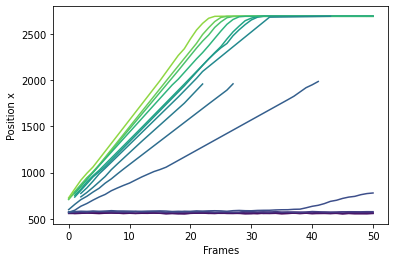

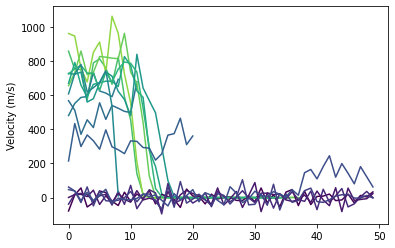

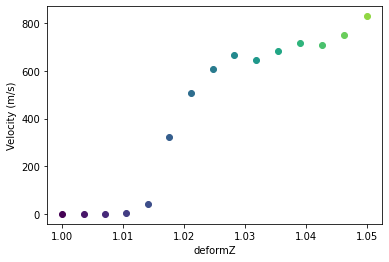

In [21]:
path = '/home/users/marthgg/simulations/rotated/angle_47.6'
pattern = 'crack_simulation_'+floating_number_pattern('deformZ')+'/fracture_displacement.npy'

collection = Collector(path, pattern, fields=('deformZ'))
simulations = collection.get_flat()

system_length = 3000
crack_start_point = 150

for deformZ, path in simulations.items():
    
    filename = path
    
    data = np.load(filename, allow_pickle=False)
    frames = list(range(0, len(data)))
    
    filtered_data_crackTip = []
    filtered_data_frames   = []
    
    for i in range(0, len(data)):
        if data[i] > crack_start_point and data[i] < system_length:
            filtered_data_crackTip.append(data[i])
            filtered_data_frames.append(frames[i])
            
    
    plt.figure(1)
    plt.plot(filtered_data_frames, filtered_data_crackTip, color=get_color_value(float(deformZ), 1.000000, 1.060000))
    plt.xlabel('Frames')
    plt.ylabel('Position x')
    
    save_figure('/home/users/marthgg/simulations/rotated/angle_47.6/frames_vs_positionX.png')
    
    # Find velocity
    timestep = 0.001 # ps
    dump_frequency = 10000
    
    time_s = []
    for i in range(0, len(filtered_data_frames)):
        time_s.append(filtered_data_frames[i]*timestep*dump_frequency*(10**-12)) #time in s
        
    position_m = []
    for i in range(0, len(filtered_data_crackTip)):
        position_m.append(filtered_data_crackTip[i]*(10**-10)) #distance in m
        
    velocity = np.diff(position_m)/np.diff(time_s)
    
    plt.figure(2)
    plt.plot(velocity, color=get_color_value(float(deformZ), 1.00000, 1.060000))#, label=deformZ)
    plt.ylabel('Velocity (m/s)')
    
    save_figure('/home/users/marthgg/simulations/rotated/angle_47.6/velocities.png')
    
    velocity_crack = []
    for i in range (0, len(velocity)):
        if filtered_data_crackTip[-1] > 2500:
            if velocity[i] < 400:
                break
            else:
                velocity_crack.append(velocity[i])
        else:
            velocity_crack.append(velocity[i])
                
    mean_velocity = np.mean(velocity_crack)

    plt.figure(3)
    plt.plot(float(deformZ), mean_velocity, 'o', color=get_color_value(float(deformZ), 1.00000, 1.060000))
    plt.xlabel('deformZ')
    plt.ylabel('Velocity (m/s)')
    
    save_figure('/home/users/marthgg/simulations/rotated/angle_47.6/deformZ_vs_velocity.png')